<a href="https://colab.research.google.com/github/upul/2016/blob/master/Chapter_07.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
!pip install -U mxnet-cu101mkl==1.6.0  # updating mxnet to at least v1.6
!pip install git+https://github.com/d2l-ai/d2l-en # installing d2l

     |████████████████████████████████| 711.0MB 27kB/s 
  Found existing installation: graphviz 0.10.1
    Uninstalling graphviz-0.10.1:
      Successfully uninstalled graphviz-0.10.1
  Cloning https://github.com/d2l-ai/d2l-en to /tmp/pip-req-build-lpxocmeh
  Running command git clone -q https://github.com/d2l-ai/d2l-en /tmp/pip-req-build-lpxocmeh
  Created wheel for d2l: filename=d2l-0.11.4-cp36-none-any.whl size=31941 sha256=9af4c11a7fb9293edea1e93eea5879c5806333c62ed1cd5e08ef4b4af23ce859
  Stored in directory: /tmp/pip-ephem-wheel-cache-892xrw_k/wheels/82/6f/b8/8422c7ed664272685e3d139b127f89df39d934704a14b2156c
Successfully built d2l


### VGG

In [0]:
import d2l
from mxnet import np, npx
from mxnet.gluon import nn
npx.set_np()

In [0]:
def vgg_block(num_convs, num_channels):
  block = nn.Sequential()
  for _ in range(num_convs):
    block.add(nn.Conv2D(num_channels, kernel_size=3, 
                        padding=1, activation='relu'))
  block.add(nn.MaxPool2D(pool_size=2, strides=2))
  return block

In [32]:
X = np.random.uniform(size=(1, 1, 10, 10))
net = vgg_block(2, 2)
net.initialize()
for stage in net:
  X = stage(X)
  print(f'name: {stage.name}, shape: {X.shape}')

name: conv34, shape: (1, 2, 10, 10)
name: conv35, shape: (1, 2, 10, 10)
name: pool17, shape: (1, 2, 5, 5)


In [0]:
conv_archi = ((1, 4), (1, 8), (2, 16), (2, 32))
def vgg(conv_archi):
  net = nn.Sequential()
  for (num_conv, num_channels) in conv_archi:
      net.add(vgg_block(num_conv, num_channels))
  
  # my dense layers
  net.add(nn.Dense(4096, activation='relu'), nn.Dropout(0.5),
          nn.Dense(1024, activation='relu'), nn.Dropout(0.5),
          nn.Dense(10))
  return net

In [44]:
net = vgg(conv_archi)
net.initialize()

X = np.random.uniform(size=(1, 1, 224, 224))
for stage in net:
  X = stage(X)
  print(f'stage: {stage.name}, shape: {X.shape}')

stage: sequential39, shape: (1, 4, 112, 112)
stage: sequential40, shape: (1, 8, 56, 56)
stage: sequential41, shape: (1, 16, 28, 28)
stage: sequential42, shape: (1, 32, 14, 14)
stage: dense10, shape: (1, 4096)
stage: dropout6, shape: (1, 4096)
stage: dense11, shape: (1, 1024)
stage: dropout7, shape: (1, 1024)
stage: dense12, shape: (1, 10)


loss 0.166, train acc 0.938, test acc 0.918
969.8 examples/sec on gpu(0)


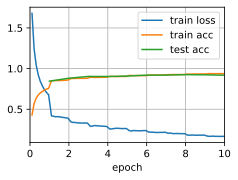

In [45]:
lr, num_epochs, batch_size = 0.05, 10, 128,
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=224)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr)

In [49]:
!nvidia-smi

Mon Apr 20 16:35:21 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.64.00    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   72C    P0    75W / 149W |   9797MiB / 11441MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

### Network in Networkx

In [0]:
def nin_block(num_channels, kernel_size, strides, padding):
  net = nn.Sequential()
  net.add(nn.Conv2D(num_channels, kernel_size, strides, padding, activation='relu'),
          nn.Conv2D(num_channels, kernel_size=1, activation='relu'),
          nn.Conv2D(num_channels, kernel_size=1, activation='relu'))
  return net 

In [54]:
X = np.random.normal(size=(1, 1, 24, 24))
net = nin_block(2, 3, 3, 1)
net.initialize()
for stage in net:
  X = stage(X)
  print(f'name: {stage.name}, shape: {X.shape}')

name: conv72, shape: (1, 2, 8, 8)
name: conv73, shape: (1, 2, 8, 8)
name: conv74, shape: (1, 2, 8, 8)


In [0]:
net = nn.Sequential()
net.add(nin_block(96, kernel_size=11, strides=4, padding=0),
        nn.MaxPool2D(pool_size=3, strides=2),
        nin_block(256, kernel_size=5, strides=1, padding=2),
        nn.MaxPool2D(pool_size=3, strides=2),
        nin_block(384, kernel_size=3, strides=1, padding=1),
        nn.MaxPool2D(pool_size=3, strides=2),
        nn.Dropout(0.5),
        # There are 10 label classes
        nin_block(10, kernel_size=3, strides=1, padding=1),
        # The global average pooling layer automatically sets the window shape
        # to the height and width of the input
        nn.GlobalAvgPool2D(),
        # Transform the four-dimensional output into two-dimensional output
        # with a shape of (batch size, 10)
        nn.Flatten())

In [56]:
X = np.random.uniform(size=(1, 1, 224, 224))
net.initialize()
for layer in net:
    X = layer(X)
    print(layer.name, 'output shape:\t', X.shape)

sequential47 output shape:	 (1, 96, 54, 54)
pool38 output shape:	 (1, 96, 26, 26)
sequential48 output shape:	 (1, 256, 26, 26)
pool39 output shape:	 (1, 256, 12, 12)
sequential49 output shape:	 (1, 384, 12, 12)
pool40 output shape:	 (1, 384, 5, 5)
dropout8 output shape:	 (1, 384, 5, 5)
sequential50 output shape:	 (1, 10, 5, 5)
pool41 output shape:	 (1, 10, 1, 1)
flatten0 output shape:	 (1, 10)


loss 0.338, train acc 0.876, test acc 0.892
472.4 examples/sec on gpu(0)


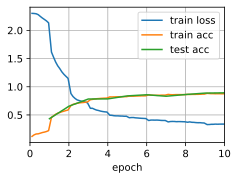

In [57]:
lr, num_epochs, batch_size = 0.1, 10, 128
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=224)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr)